In [1]:
!pip install ta

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=c5b4b80897590fec4ac53a6b8b79da19b013e72f8b54c71fcb68c0b7601a011d
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


## Data processing

To predict short-term market behavior, the first step in this project is to construct an historical dataset based on technical analysis indicators.

We begin by retrieving the current list of S&P 500 tickers from Wikipedia. For each stock, we download historical daily data from Yahoo Finance, including open, high, low, close prices, and trading volume.

Common trading signals are derived as follows:

- **Trend indicators:**
  - Simple Moving Averages (SMA) over 10, 20, and 50 days
  - Slope of each SMA (daily change) to capture the direction of the trend
  - Price distance from each SMA to quantify how extended the current price is from typical levels

- **Momentum indicators:**
  - Relative Strength Index (RSI) over 14 days
  - A binary feature that flags when RSI is between 50 and 70—a zone often interpreted as bullish but not yet overbought

- **MACD signals:**
  - MACD line and its signal line
  - Boolean flags for bullish crossovers (today, yesterday, and two days ago)
  - A persistent signal showing whether MACD remains above its signal line

- **Volume analysis:**
  - 10-day average volume
  - Booleans for volume above the 10-day average or previous day's volume

- **Breakout and volatility signals:**
  - A flag for when today's high exceeds the rolling 5-day high
  - Candlestick attributes: body size, upper wick, and lower wick

The target variable is binary. It is set to 1 if the current day's **low is lower than the lows of each of the next five trading days**. Otherwise, the target is 0.

In [2]:
# ------------- Step 1: Get S&P 500 Tickers -------------
def get_sp500_tickers():
    table = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
    return table[0]['Symbol'].tolist()

# ------------- Step 2: Build Historical Dataset -------------
def compute_features_and_target_batched(price_data):
    # Flatten and reshape price data correctly
    df = price_data.copy()
    df = price_data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)
    df.sort_values(by=['Ticker', 'Date'], inplace=True)

    df['Date'] = df.index
    df = df.reset_index(drop=True)

    # Add technical indicators
    df['SMA10'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(10).mean())
    df['SMA20'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(20).mean())
    df['SMA50'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(50).mean())
    df['AvgVol10'] = df.groupby('Ticker')['Volume'].transform(lambda x: x.rolling(10).mean())
    df['RSI'] = df.groupby('Ticker')['Close'].transform(lambda x: RSIIndicator(x, window=14).rsi())

    df['MACD'] = df.groupby('Ticker')['Close'].transform(lambda x: MACD(x).macd())
    df['MACD_signal'] = df.groupby('Ticker')['Close'].transform(lambda x: MACD(x).macd_signal())

    # Feature Engineering
    # SMA crossing
    df['CrossSMA10'] = (df['Close'] > df['SMA10']) & (df['Close'].shift(1) < df['SMA10'].shift(1))
    df['CrossSMA20'] = (df['Close'] > df['SMA20']) & (df['Close'].shift(1) < df['SMA20'].shift(1))
    df['CrossSMA50'] = (df['Close'] > df['SMA50']) & (df['Close'].shift(1) < df['SMA50'].shift(1))

    # SMA slope
    df['SMA10_Slope'] = df.groupby('Ticker')['SMA10'].transform(lambda x: x.diff())
    df['SMA20_Slope'] = df.groupby('Ticker')['SMA20'].transform(lambda x: x.diff())
    df['SMA50_Slope'] = df.groupby('Ticker')['SMA50'].transform(lambda x: x.diff())

    # Distance from SMA
    df['Dist_From_SMA10'] = (df['Close'] - df['SMA10']) / df['SMA10']
    df['Dist_From_SMA20'] = (df['Close'] - df['SMA20']) / df['SMA20']
    df['Dist_From_SMA50'] = (df['Close'] - df['SMA50']) / df['SMA50']

    # RSI
    df['RSI_Between_50_70'] = (df['RSI'] > 50) & (df['RSI'] < 70)

    # MACD
    df['MACD_Cross_Today'] = (df['MACD'] > df['MACD_signal']) & (df['MACD'].shift(1) <= df['MACD_signal'].shift(1))
    df['MACD_Cross_Yesterday'] = (df['MACD'].shift(1) > df['MACD_signal'].shift(1)) & (df['MACD'].shift(2) <= df['MACD_signal'].shift(2))
    df['MACD_Cross_2DaysAgo'] = (df['MACD'].shift(2) > df['MACD_signal'].shift(2)) & (df['MACD'].shift(3) <= df['MACD_signal'].shift(3))
    df['MACD_Above_Signal'] = df['MACD'] > df['MACD_signal']

    # Volumes
    df['Vol_GT_Avg10'] = df['Volume'] > df['AvgVol10']
    df['Vol_GT_Prev'] = df['Volume'] > df.groupby('Ticker')['Volume'].shift(1)
    df['High_GT_Last5'] = df['High'] > df.groupby('Ticker')['High'].shift(1).rolling(5).max()

    # Candlestick patterns
    df['Body_Size'] = abs(df['Close'] - df['Open'])
    df['Upper_Wick'] = df['High'] - df[['Close', 'Open']].max(axis=1)
    df['Lower_Wick'] = df[['Close', 'Open']].min(axis=1) - df['Low']

    # Compute target
    for i in range(1, 6):
      df[f'next_low_{i}'] = df.groupby('Ticker')['Low'].shift(-i)

    df['Target'] = (
    (df['Low'] < df['next_low_1']) &
    (df['Low'] < df['next_low_2']) &
    (df['Low'] < df['next_low_3']) &
    (df['Low'] < df['next_low_4']) &
    (df['Low'] < df['next_low_5'])
    )

    df['Target'] = df['Target'].astype(int)

    # Optional: clean up helper columns
    df.drop(columns=[f'next_low_{i}' for i in range(1, 6)], inplace=True)

    feature_cols = ['CrossSMA10', 'CrossSMA20', 'CrossSMA50', 'RSI_Between_50_70',
                    'MACD_Cross_Today', 'MACD_Cross_Yesterday', 'MACD_Cross_2DaysAgo',
                    'MACD_Above_Signal', 'Vol_GT_Avg10', 'Vol_GT_Prev', 'High_GT_Last5', 'Dist_From_SMA20']

    feature_cols2 = ['Dist_From_SMA10', 'Dist_From_SMA20', 'Dist_From_SMA50',
                     'SMA10_Slope', 'SMA20_Slope', 'SMA50_Slope',
                     'Body_Size', 'Upper_Wick', 'Lower_Wick']

    return df[['Date', 'Ticker'] + feature_cols + ['Target']].reset_index(drop=True)

In [3]:
# Get price data

tickers = get_sp500_tickers()
price_data = yf.download(tickers, start="2010-01-01", end=datetime.today().strftime('%Y-%m-%d'), group_by="ticker", auto_adjust=False, threads=True)

[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2025-06-25)')
ERROR:yfinance:['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


In [4]:
# Build predictors

full_data = compute_features_and_target_batched(price_data)

/tmp/ipython-input-2-1984875779.py:10: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = price_data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)


## Logistic regression

With the feature dataset constructed, the next step is to train a classification model that can estimate the likelihood of a stock reaching a local bottom. For this purpose, a logistic regression model is chosen, mainly for the execution speed and interpretability.

The data is then split into a training set (80%) and a test set (20%), ensuring class balance through stratified sampling.

To ensure robust model selection, a hyperparameter search is conducted using `GridSearchCV` over five cross-validation folds. The hyperparameter that is tuned is the regularization strength, tested across values from 0.001 to 1.0.

The grid search optimizes for **precision**, in order to minimize false positives.

Once the best hyperparameter is found, the model is retrained on the full training set and evaluated on the test set. The evaluation metrics include:
- **Accuracy:** Overall correctness of predictions
- **Precision:** The proportion of predicted positive signals that were correct
- **Recall:** The proportion of actual positives that were correctly identified
- **AUC (Area Under the Curve):** The model’s ability to rank positive examples above negative ones

In [5]:
# ------------- Step 3: Train, Tune, and Evaluate Model -------------
def tune_and_evaluate_model(data):
    data = data.dropna()
    X = data.drop(columns=['Target', 'Date', 'Ticker'])
    y = data['Target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"\nNumber of observations used for training: {len(X_train)}")
    print(f"\nNumber of observations used for testing: {len(X_test)}")

    param_grid = {
        'C': [0.001, 0.01, 0.05, 0.1, 1.0],
        'penalty': ['l2'],
        'solver': ['lbfgs']
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=cv, scoring='precision', n_jobs=-1)
    grid.fit(X_train, y_train)

    print("\n=== Best Parameters ===")
    print(grid.best_params_)

    model = grid.best_estimator_
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("\n=== Test Performance ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print("\n=== Classification report ===")
    print(classification_report(y_test, y_pred))

    return {
        'model': model,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

# ------------- Step 4: Run Full Pipeline -------------
def run_pipeline():
    tickers = get_sp500_tickers()
    print("Downloading price data for all tickers...")
    price_data = yf.download(tickers, start="2010-01-01", end=datetime.today().strftime('%Y-%m-%d'), group_by="ticker", auto_adjust=True, threads=True)

    print("Building feature matrix...")
    full_data = compute_features_and_target_batched(price_data)

    if full_data is None:
        print("No valid data for training.")
        return

    results = tune_and_evaluate_model(full_data)
    return results

In [6]:
# Train model

results = tune_and_evaluate_model(full_data)


Number of observations used for training: 1468369

Number of observations used for testing: 367093

=== Best Parameters ===
{'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}

=== Test Performance ===
Accuracy: 0.7072
Precision: 0.5379
Recall: 0.0365
AUC: 0.5795

=== Classification report ===
              precision    recall  f1-score   support

           0       0.71      0.99      0.83    259042
           1       0.54      0.04      0.07    108051

    accuracy                           0.71    367093
   macro avg       0.62      0.51      0.45    367093
weighted avg       0.66      0.71      0.60    367093



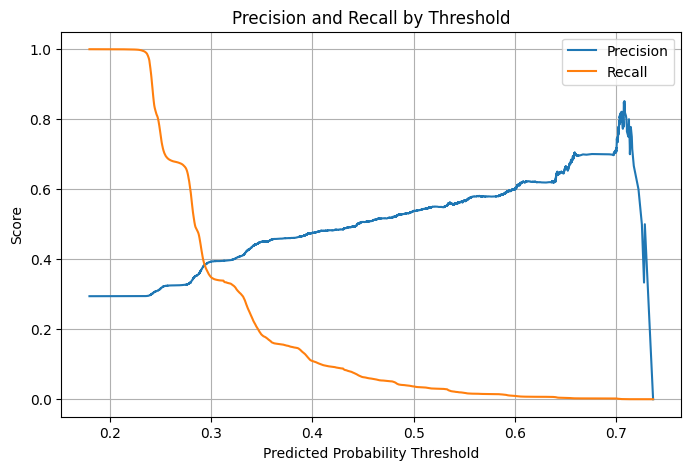

In [8]:
# Unpack model results
y_test = results['y_test']
y_pred = results['y_pred']
y_proba = results['y_proba']

# Combine into a DataFrame for inspection
results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Predicted_Prob': y_proba
})
results_df.index = y_test.index  # preserve index for merging

# Merge with feature set to retrieve additional info (e.g., Return_5D if available)
X_test = results['X_test']
combined = X_test.copy()
combined['Actual'] = results_df['Actual']
combined['Predicted'] = results_df['Predicted']
combined['Predicted_Prob'] = results_df['Predicted_Prob']

# Include return info if available
if 'test_returns' in results:
    combined['Return_5D'] = results['test_returns']

# --- 2. Precision-Recall Curve ---
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Predicted Probability Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall by Threshold")
plt.legend()
plt.grid(True)
plt.show()

Overall, the model achieves an accuracy of 71% on the test set. Among the instances predicted as positive, 54% are true positives when a 0.5 probability threshold is considered. When the threshold probability is increased at 60%, 60% of predicted breakouts are correctly identified.

However, the model only identifies 4% of all actual positive cases. This suggests that while the model is conservative in making positive predictions, it misses many true opportunities.

In [7]:
# Show logistic regression coefficients
# Get feature names (must match order used in training)
feature_names = results['X_train'].columns

# Get the coefficients from the model
coefficients = results['model'].coef_[0]

# Combine into a DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df)

                 Feature  Coefficient
11       Dist_From_SMA20     0.529682
0             CrossSMA10     0.508246
2             CrossSMA50     0.441177
1             CrossSMA20     0.361755
4       MACD_Cross_Today     0.237468
10         High_GT_Last5     0.203217
8           Vol_GT_Avg10     0.195789
5   MACD_Cross_Yesterday    -0.055487
7      MACD_Above_Signal     0.032683
3      RSI_Between_50_70    -0.021659
6    MACD_Cross_2DaysAgo    -0.021460
9            Vol_GT_Prev     0.013895


Overall, the model places the greatest weight on SMA crossovers and price position relative to trend indicators, supporting the idea that short-term trend reversals are a strong basis for identifying local bottoms.

- **Strongest Positive Signals:**
  - `Dist_From_SMA20` (0.530): A price significantly above the 20-day SMA increases the likelihood of a local minimum.
  - `CrossSMA10`, `CrossSMA50` and `CrossSMA20` show strong positive contributions, reinforcing the importance of trend reversals.

- **Momentum and Volume-Based Signals:**
  - `MACD_Cross_Today` (0.237) and `High_GT_Last5` (0.203): A fresh MACD bullish crossover and a new local high both contribute positively.
  - `Vol_GT_Avg10` (0.196): Higher-than-average volume supports the signal's strength, consistent with breakouts being more reliable under heavy trading activity.

- **Weak or Negative Contributors:**
  - `MACD_Cross_Yesterday` (-0.055): A crossover that occurred a day ago may have diminishing predictive power, possibly due to a delayed signal or market reaction already priced in.
  - `RSI_Between_50_70` (-0.021): Being in the neutral-to-bullish RSI range slightly lowers the predicted probability, which may suggest that stronger signals lie outside this zone (e.g., oversold conditions).
  - `MACD_Cross_2DaysAgo` (-0.021) and `MACD_Above_Signal` (0.033): Older MACD signals contribute weakly or negatively, reinforcing the importance of timeliness.

## Backtesting strategy

To evaluate how well the model’s predictions translate into real performance, a backtesting routine is simulated. The logic follows a conservative long-only strategy with defined risk management rules.

#### Entry Conditions
A trade is initiated when the model predicts a probability greater than 0.5 for the `Target = 1` class. For each qualifying instance:
- The trade is opened at the **closing price** on the prediction day.
- The trade is held for **up to 5 trading days**, unless exited earlier by hitting stop-loss or take-profit levels.

#### Risk Management
To manage risk and exits, each trade uses two stop-loss mechanisms and one take-profit:
- **ATR-based Stop-Loss:** A dynamic stop-loss set at 1.5 × ATR(14) below the entry price. This adapts to recent volatility.
- **Percentage Stop-Loss:** A fixed 2% drop from the entry price.
- **Take-Profit Target:** Set at 2 × ATR(14) above the entry price.

The **first level breached** among these three conditions determines the exit. If none are triggered within five days, the position is closed at the **end of day 5's closing price**.


In [9]:
def backtest_strategy(model_results, full_data, price_data):
    model = model_results['model']
    X_test = model_results['X_test']
    y_test = model_results['y_test']
    prob = model.predict_proba(X_test)[:, 1]

    trades = []

    for iloc_index in range(len(X_test)):
        original_full_data_index = X_test.index[iloc_index]
        current_prob = prob[iloc_index]
        current_actual = y_test.iloc[iloc_index]

        if current_prob <= 0.5:
            continue

        try:
            entry_row_data = full_data.loc[original_full_data_index]
        except KeyError:
            continue

        entry_date = entry_row_data['Date']
        ticker = entry_row_data['Ticker']

        try:
            df_ticker = price_data[ticker].copy()
        except KeyError:
            continue

        try:
            entry_idx_in_price_df = df_ticker.index.get_loc(entry_date)
        except KeyError:
            continue

        if entry_idx_in_price_df + 5 >= len(df_ticker):
            continue

        try:
            entry_price = df_ticker.loc[entry_date, 'Close']
        except KeyError:
            continue

        atr_start_iloc = max(0, entry_idx_in_price_df - 13)
        atr_data = df_ticker.iloc[atr_start_iloc:entry_idx_in_price_df + 1]

        if len(atr_data) < 14:
            tr = pd.Series(index=atr_data.index)
            tr.iloc[0] = atr_data.iloc[0]['High'] - atr_data.iloc[0]['Low']
            for i in range(1, len(atr_data)):
                high_low = atr_data.iloc[i]['High'] - atr_data.iloc[i]['Low']
                high_prevclose = abs(atr_data.iloc[i]['High'] - atr_data.iloc[i - 1]['Close'])
                low_prevclose = abs(atr_data.iloc[i]['Low'] - atr_data.iloc[i - 1]['Close'])
                tr.iloc[i] = max(high_low, high_prevclose, low_prevclose)
            atr14 = tr.mean()
        else:
            high_low = atr_data['High'] - atr_data['Low']
            high_prevclose = abs(atr_data['High'] - atr_data['Close'].shift(1))
            low_prevclose = abs(atr_data['Low'] - atr_data['Close'].shift(1))
            tr = pd.concat([high_low, high_prevclose, low_prevclose], axis=1).max(axis=1)
            atr14_series = tr.rolling(14).mean()
            atr14 = atr14_series.iloc[-1]

        if pd.isna(atr14) or atr14 <= 0:
            continue

        stop_price_1 = entry_price - 1.5 * atr14
        stop_price_2 = entry_price * 0.98
        take_profit = entry_price + 2 * atr14

        trade_closed = False
        for j in range(entry_idx_in_price_df + 1, min(entry_idx_in_price_df + 5, len(df_ticker))):
            future_date = df_ticker.index[j]
            low = df_ticker.loc[future_date, 'Low']
            high = df_ticker.loc[future_date, 'High']
            close = df_ticker.loc[future_date, 'Close']

            if high >= take_profit:
                trades.append({
                    'Ticker': ticker,
                    'Entry_Date': entry_date,
                    'Exit_Date': future_date,
                    'Entry_Price': entry_price,
                    'Exit_Price': take_profit,
                    'TP_or_SL': 'TP',
                    'Predicted_Prob': current_prob,
                    'Actual': current_actual,
                    'Return': round((take_profit - entry_price) / entry_price, 4)
                })
                trade_closed = True
                break
            elif low <= stop_price_2:
                trades.append({
                    'Ticker': ticker,
                    'Entry_Date': entry_date,
                    'Exit_Date': future_date,
                    'Entry_Price': entry_price,
                    'Exit_Price': stop_price_2,
                    'TP_or_SL': 'SL_Pct',
                    'Predicted_Prob': current_prob,
                    'Actual': current_actual,
                    'Return': round((stop_price_2 - entry_price) / entry_price, 4)
                })
                trade_closed = True
                break
            elif close <= stop_price_1:
                trades.append({
                    'Ticker': ticker,
                    'Entry_Date': entry_date,
                    'Exit_Date': future_date,
                    'Entry_Price': entry_price,
                    'Exit_Price': close,
                    'TP_or_SL': 'SL_ATR',
                    'Predicted_Prob': current_prob,
                    'Actual': current_actual,
                    'Return': round((close - entry_price) / entry_price, 4)
                })
                trade_closed = True
                break

        if not trade_closed:
            final_day = df_ticker.iloc[entry_idx_in_price_df + 5]
            trades.append({
                'Ticker': ticker,
                'Entry_Date': entry_date,
                'Exit_Date': final_day.name,
                'Entry_Price': entry_price,
                'Exit_Price': final_day['Close'],
                'TP_or_SL': 'MaxHoldExit',
                'Predicted_Prob': current_prob,
                'Actual': current_actual,
                'Return': round((final_day['Close'] - entry_price) / entry_price, 4)
            })

    return pd.DataFrame(trades)


In [10]:
backtest_results = backtest_strategy(results, full_data, price_data)
backtest_results

,Ticker,Entry_Date,Exit_Date,Entry_Price,Exit_Price,TP_or_SL,Predicted_Prob,Actual,Return
0,GNRC,2016-06-20,2016-06-21,38.020000,37.259600,SL_Pct,0.540855,0,-0.0200
1,CAG,2024-01-17,2024-01-19,28.910000,28.331800,SL_Pct,0.540287,0,-0.0200
2,LLY,2017-01-31,2017-02-07,77.029999,77.699997,MaxHoldExit,0.534844,1,0.0087
3,FDX,2020-06-30,2020-07-01,140.220001,150.344287,TP,0.535602,1,0.0722
4,HIG,2018-05-15,2018-05-22,52.730000,53.750000,MaxHoldExit,0.548576,1,0.0193
...,...,...,...,...,...,...,...,...,...
7304,ESS,2010-08-31,2010-09-03,105.769997,110.545711,TP,0.700886,1,0.0452
7305,PLD,2021-01-15,2021-01-25,97.680000,102.699997,MaxHoldExit,0.549053,1,0.0514
7306,CHD,2015-03-16,2015-03-23,42.750000,43.090000,MaxHoldExit,0.533803,0,0.0080
7307,VRSK,2013-07-31,2013-08-07,64.360001,63.360001,MaxHoldExit,0.609406,1,-0.0155


In [18]:
# Compute summary stats by exit type among prob > 0.6
filtered = backtest_results[backtest_results['Predicted_Prob'] > 0.6]

summary_stats = filtered['Return'].agg(['count', 'mean', 'min', 'median', 'max']).round(4)

# Compute win rate (Return > 0)
win_rate = (filtered['Return'] > 0).mean().round(4)

# Append win rate to summary
summary_stats.loc['win_rate'] = win_rate

summary_stats

,Return
count,1749.0000
mean,0.0023
min,-0.0678
median,-0.0158
max,0.1229
win_rate,0.4180


In [24]:
# Compute summary stats by exit type among prob > 0.6 by type of exit
summary_stats_by_group = (
    filtered
    .groupby(['TP_or_SL'])['Return']
    .agg(['count', 'mean', 'min', 'median', 'max'])
    .round(2)
)

# Compute win rate (Return > 0)
win_rate = filtered.groupby(['TP_or_SL'])['Return'].apply(lambda x: (x > 0).mean()).round(4)

# Append win rate to summary
summary_stats_by_group['win_rate'] = win_rate

summary_stats_by_group

,count,mean,min,median,max,win_rate
TP_or_SL,,,,,,
MaxHoldExit,673,0.01,-0.07,0.01,0.12,0.7028
SL_ATR,2,-0.02,-0.02,-0.02,-0.02,0.0000
SL_Pct,816,-0.02,-0.02,-0.02,-0.02,0.0000
TP,258,0.05,0.02,0.04,0.12,1.0000


Out of the 1,749 trades executed, only 42% result in a positive outcome but the average return remains positive, at 0.2%.

Distinguishing by the exit type, we observe that trades that are held for five periods result in more than 70% success with 1% return.

## Train final model and predict on new data

We finally train the model on the full data, with the objective of predicting the potential breakouts of the day.

In [ ]:
def train_full_model(data, best_params):
    data = data.dropna()
    X = data.drop(columns=['Target', 'Date', 'Ticker'])
    y = data['Target']
    model = LogisticRegression(**best_params, max_iter=1000)
    model.fit(X, y)
    return model

def predict_last_day(model, full_data):
    # Get the last available row per ticker
    latest_rows = full_data.sort_values('Date').groupby('Ticker').tail(1).copy()

    # Prepare input features
    feature_cols = ['CrossSMA10', 'CrossSMA20', 'CrossSMA50', 'RSI_Between_50_70',
                    'MACD_Cross_Today', 'MACD_Cross_Yesterday', 'MACD_Cross_2DaysAgo',
                    'MACD_Above_Signal', 'Vol_GT_Avg10', 'Vol_GT_Prev', 'High_GT_Last5', 'Dist_From_SMA20']

    X_latest = latest_rows[feature_cols]
    latest_rows['Predicted_Prob'] = model.predict_proba(X_latest)[:, 1]

    return latest_rows[['Date', 'Ticker', 'Predicted_Prob'] + feature_cols]

In [ ]:
# Extract best params and full dataset
best_params = results['model'].get_params()
relevant_params = {k: best_params[k] for k in ['C', 'penalty', 'solver']}  # keep only tuned params

final_model = train_full_model(full_data, relevant_params)

# Predict on most recent data
latest_predictions = predict_last_day(final_model, full_data)
print(latest_predictions[latest_predictions['Predicted_Prob'] > 0.6].sort_values(by='Predicted_Prob', ascending=False).head(10))